In [65]:
import math

import numpy as np
import gymnasium as gym

from gymnasium import spaces

In [63]:
from importnb import Notebook
with Notebook():
    from LabCacheService import CacheService

cache = CacheService(capacity_bytes=2_000_000_000)

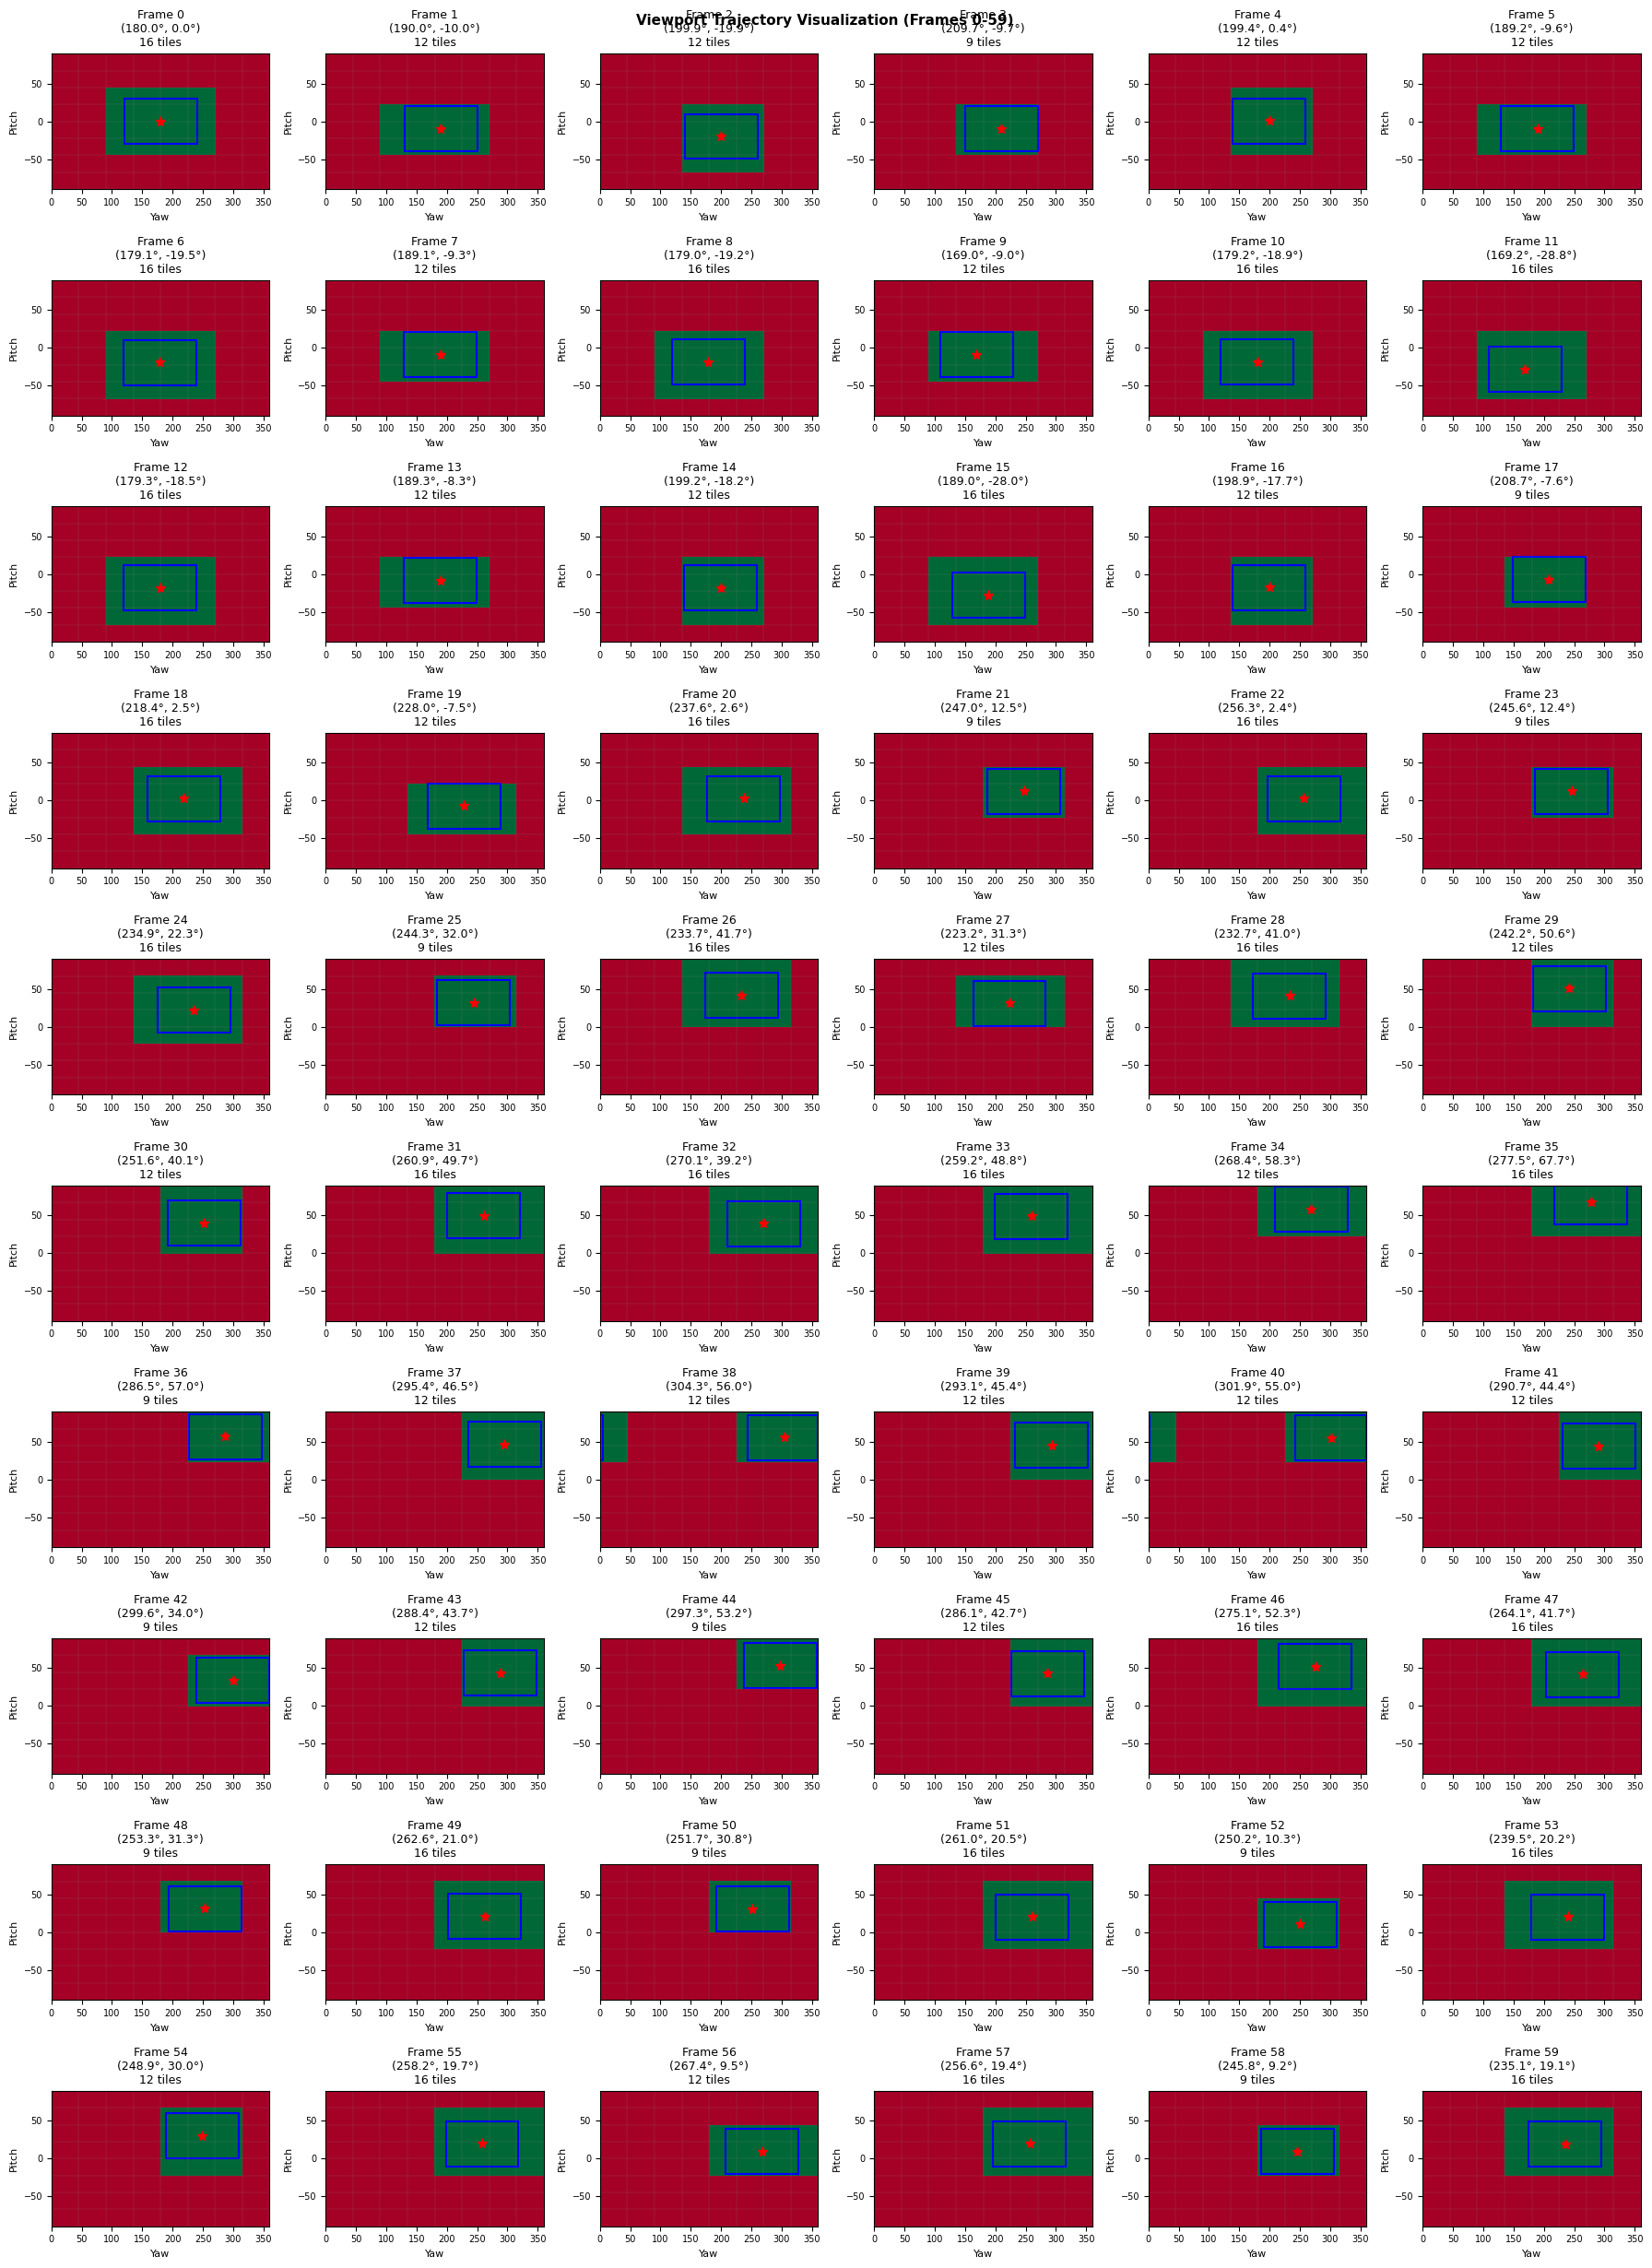

In [ ]:
from importnb import Notebook
with Notebook():
    from LabTrajectory import simulate_viewport_with_tiles, visualize_trajectory_sequence

n_frames = 1_800
num_tiles = 8

yaw, pitch, tiles_per_frame, tiles_array = simulate_viewport_with_tiles(
    num_steps=n_frames,
    n=num_tiles,
    fov_yaw=120,
    fov_pitch=60,
    damping=0.99,
    step_size=10,
    start_yaw=180,
    start_pitch=0
)
user_tiles = tiles_per_frame[:60]
visualize_trajectory_sequence(
    yaw, 
    pitch, 
    user_tiles, 
    n=num_tiles, 
    fov_yaw=120, 
    fov_pitch=60,
    start_frame=0, 
    num_frames_to_show=60, 
    cols=6
)

In [ ]:
# CPT parameters (typical values from literature; adjustable)
alpha = 0.88  # gain curvature
beta = 0.88   # loss curvature
lam = 2.25    # loss aversion (losses weighted more)
prelec_gamma = 0.65  # probability weighting parameter (Prelec)
n = 8
num_tiles = n*n
class CPTPrefetchEnvSimple(gym.Env):
    def __init__(
        self, 
        n_users: int = 1,
        cache_capacity: int = 10,
    ):
        super(CPTPrefetchEnvSimple, self).__init__()
        self.action_space = spaces.Discrete(2)  # Example: two discrete actions
        self.observation_space = spaces.Box(
            low=0, 
            high=1, 
            shape=(4,), 
            dtype=np.float32
        )  # Example: 4D continuous observation


        self.capacity = self.cache_capacity = cache_capacity
        self.sizes = np.random.randint(1, 4, size=num_tiles) 

        self.gain_if_prefetched = 1.0
        self.loss_if_not_prefetched = -2.0

        self.gamma = 0.7
        self.alpha = 0.88
        self.beta = 0.88
        self.lam = 2.25

        self.current_p = np.zeros(num_tiles, dtype=float)

    def reset(self):
        self.state = np.random.rand(4)  # Example initial state
        return self.state
    
    def step(self, action):
        self.state = np.random.rand(4)
        reward     = 0.0
        done       = np.random.rand() > 0.95        
        info       = {}

        n_prefetch = int(action.sum())
        info = {
            "n_prefetch_requested": n_prefetch, 
            "capacity": self.capacity, 
            "prefetch_indices": np.where(action==1)[0].tolist()
        }

        # Enforce capacity constraint and compute penalty if exceeded
        if n_prefetch > self.capacity:
            selected = np.where(action == 1)[0]
            to_drop = n_prefetch - self.capacity
            sel_sorted = selected[np.argsort(self.current_p[selected])]
            drop = sel_sorted[:to_drop]
            action[drop] = 0
            info["clipped_dropped_indices"] = drop.tolist()
            penalty = -0.5 * to_drop
            reward += penalty

        reward += self.compute_expected_cpt_reward(action)

        return self.state, reward, done, info

    def compute_expected_cpt_reward(self, action: np.ndarray) -> float:
        expected_reward = 0.0
        for tile in range(num_tiles):
            p = float(self.current_p[tile])
            w = self.prelec_w(p)
            if action[tile] == 1:
                expected_outcome = p * self.gain_if_prefetched
            else:
                expected_outcome = p * self.loss_if_not_prefetched
            
            v = self.cpt_value(expected_outcome, alpha=self.alpha, beta=self.beta, lam=self.lam)
            expected_reward += w * v

        return float(expected_reward)

    def u_gain(self, x):
        return x**alpha

    def u_loss(self, x):
        return -lam * ((-x)**beta)
    
    def prelec_w(self, p):    # Prelec probability weighting function
        p = np.clip(p, 1e-12, 1-1e-12)
        return math.exp(-((-math.log(p))**prelec_gamma))

    def cpt_value(self, x: float, alpha: float = 0.88, beta: float = 0.88, lam: float = 2.25) -> float:
        if x >= 0:
            return x ** alpha
        else:
            return -lam * ((-x) ** beta)


In [60]:
if __name__ == '__main__':
    env = CPTPrefetchEnvSimple()
    obs = env.reset()
    done = False
    total_reward = 0.0

    while not done:
        action = env.action_space.sample()  # Random action
        obs, reward, done, info = env.step(action)
        total_reward += reward
        print(f"Obs: {obs}, Reward: {reward}, Done: {done}")

    print(f"Total reward: {total_reward}")

Obs: [0.80845583 0.19190154 0.27159384 0.99097134], Reward: 0.16462182487853805, Done: False
Obs: [0.16645123 0.8396102  0.78117473 0.75930303], Reward: 0.8258239884288866, Done: False
Obs: [0.95880071 0.07197484 0.23598737 0.83076329], Reward: 0.6767856123296585, Done: False
Obs: [0.30603471 0.02445274 0.82783433 0.7626629 ], Reward: 0.42015163335620676, Done: False
Obs: [0.61995008 0.55246594 0.00564483 0.12684777], Reward: 0.10142426518388636, Done: False
Obs: [0.9670956  0.42467251 0.65349632 0.23930793], Reward: 0.6681267349763875, Done: False
Obs: [0.13698895 0.57832931 0.07145978 0.2679571 ], Reward: 0.1447495321420419, Done: False
Obs: [0.18179517 0.95437511 0.1881542  0.31037482], Reward: 0.2114524183218005, Done: False
Obs: [0.13884544 0.81904991 0.63812949 0.25209624], Reward: 0.5132029572317958, Done: False
Obs: [0.04969004 0.53633372 0.07573385 0.70954044], Reward: 0.38475904587090237, Done: False
Obs: [0.32379554 0.18865327 0.91729741 0.86985345], Reward: 0.04486372280199